## やっていること
* 速度加速度を作成



### TODO
* 加速度データをlng, lat方向に修正
* だが，重力方向が不明(坂道だと重力方向がずれる)
* マップデータが使用できれば傾斜情報を使用できるので期待


In [1]:
using DataFrames
using DataFramesMeta
using CategoricalArrays
using Pipe
using JLD2
using Dates
using LeapSeconds
using Combinatorics
using Random
using Statistics
using Profile
using ProgressMeter
using LinearAlgebra
# using Base.Threads
using CSV
using Glob
using Formatting
using DelimitedFiles
using TextAnalysis
using BenchmarkTools
using FFTW
using Optim
ENV["COLUMNS"] =1000
ENV["ROWS"]= 20
F = Float64
S = Symbol 

using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 6
rcParams["figure.figsize"] = [9,9]
rcParams["figure.dpi"] = 220
plt.style.use("seaborn-darkgrid");

In [1]:
using DataFrames
using DataFramesMeta
using JLD2
using BenchmarkTools 
include("../src/util_fc.jl") #using util_fc
@load "../DataFrames/train_df_concat_20.jdl2" train_df_concat
util_fc.lnglat2XY(train_df_concat, :lngDeg, :latDeg, :X_obs, :Y_obs)
const F = Float64
const S = Symbol 

Symbol

In [2]:
include("../src/util_fc.jl") #using util_fc

Main.util_fc

In [3]:
@load "../DataFrames/train_df_concat_20.jdl2" train_df_concat
@load "../DataFrames/test_df_concat_20.jdl2" test_df_concat

1-element Array{Symbol,1}:
 :test_df_concat

In [6]:
train_df_concat1 = deepcopy(train_df_concat);
train_df_concat2 = deepcopy(train_df_concat);
for i in 1:100
    append!(train_df_concat,train_df_concat1) 
end

In [113]:
util_fc.lnglat2XY(train_df_concat, :lngDeg, :latDeg, :X_obs, :Y_obs)

In [32]:
function XY2acce(X, X_out)
    ΔT = 0.1
    ΔT_2 = 1.0 / ΔT^2
    n = size(X,1)
    @inbounds for i in 2:n-1
        @views X_out[i] = (X[i-1] - 2.0*X[i] + X[i+1]) * ΔT_2
    end
    X_out[1] = X_out[2]
    X_out[n] = X_out[n-1]
    nothing
end

function XY2acce(df::DataFrame, X, Y)
    Ax= S("Ax_$(X)")
    Ay= S("Ay_$(Y)")
    df[!, Ax] = similar(df[!, X])#Vector{F}(undef, n)
    df[!, Ay] = similar(df[!, X])#Vector{F}(undef, n)
    gd = groupby(df, :phone)
    for gdf in gd
        XY2acce(gdf[!,X], gdf[!,Ax])
        XY2acce(gdf[!,X], gdf[!,Ay])
    end
    Ax, Ay
end

function XY2acce2(X)
    ΔT = 1.0
    n = size(X,1)
    acx = similar(X, F)
    ΔT_2 = 1.0 / ΔT^2
    @simd for i in 2:n-1
       @inbounds  acx[i] = (X[i-1] - 2.0*X[i] + X[i+1])* ΔT_2 
    end
    acx[1] = acx[2]
    acx[n] = acx[n-1]
    return acx
end

function XY2acce2(df::DataFrame, X, Y)
    gd = groupby(df, :phone)
    transform!(gd, X => (XY2acce2 => :Ax_X_obs))
    transform!(gd, Y => (XY2acce2 => :Ay_Y_obs))
    # @transform!(gd, Ay_Y_obs=XY2acce2(cols(Y)))
end

function XY2acce3(df::DataFrame, X, Y)
    gd = groupby(df, :phone)
    # @transform!(gd, Ax_X_obs=XY2acce2(cols(X)))
    cdf  = @combine(gd, Ay_Y_obs=mean(cols(Y)))
    return cdf
end
# @benchmark XY2acce2(train_df_concat2, :X_obs,:Y_obs)
# @benchmark XY2acce(train_df_concat1, :X_obs, :Y_obs)

XY2acce3 (generic function with 1 method)

In [33]:
XY2acce3(train_df_concat, :X_obs,:Y_obs)

,phone,Ay_Y_obs
,String,Float64
1,2020-05-14-US-MTV-1_Pixel4,9753.01
2,2020-05-14-US-MTV-1_Pixel4XLModded,9843.2
3,2020-05-14-US-MTV-2_Pixel4,12190.9
4,2020-05-14-US-MTV-2_Pixel4XLModded,23033.6
5,2020-05-21-US-MTV-1_Pixel4,10154.5
6,2020-05-21-US-MTV-2_Pixel4,9541.99
7,2020-05-21-US-MTV-2_Pixel4XL,10699.6
8,2020-05-29-US-MTV-1_Pixel4,-1923.1
9,2020-05-29-US-MTV-1_Pixel4XL,-1916.66


In [35]:
@time XY2acce3(train_df_concat, :X_obs,:Y_obs)

  0.848682 seconds (346 allocations: 1.087 GiB, 0.68% gc time)


,phone,Ay_Y_obs
,String,Float64
1,2020-05-14-US-MTV-1_Pixel4,9753.01
2,2020-05-14-US-MTV-1_Pixel4XLModded,9843.2
3,2020-05-14-US-MTV-2_Pixel4,12190.9
4,2020-05-14-US-MTV-2_Pixel4XLModded,23033.6
5,2020-05-21-US-MTV-1_Pixel4,10154.5
6,2020-05-21-US-MTV-2_Pixel4,9541.99
7,2020-05-21-US-MTV-2_Pixel4XL,10699.6
8,2020-05-29-US-MTV-1_Pixel4,-1923.1
9,2020-05-29-US-MTV-1_Pixel4XL,-1916.66


In [28]:
size(train_df_concat, 1)
Base.summarysize(train_df_concat.X_obs) /10^(3*3)

1.167367736

In [29]:
size(train_df_concat, 1) |> log10

8.164117684127943

In [11]:
@benchmark XY2acce2(train_df_concat, :X_obs,:Y_obs)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 34.025 s (12.66% GC) to evaluate,
 with a memory estimate of 30.90 GiB, over 1167370325 allocations.

In [37]:
@benchmark XY2acce3(train_df_concat2, :X_obs,:Y_obs)

BenchmarkTools.Trial: 156 samples with 1 evaluation.
 Range (min … max):  29.488 ms … 36.703 ms  ┊ GC (min … max): 0.00% … 15.08%
 Time  (median):     30.514 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.249 ms ±  2.489 ms  ┊ GC (mean ± σ):  7.05% ±  7.59%

     ▁▂█ ▁                                         ▁▁          
  ▃▆████▅██▅▄▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▃▃▃▆▃▇██▅▇▆▃▅▄▁▃ ▃
  29.5 ms         Histogram: frequency by time          36 ms <

 Memory estimate: 41.90 MiB, allocs estimate: 1053256.

In [26]:
@code_warntype XY2acce2(train_df_concat2, :X_obs,:Y_obs)

Variables
  #self#::Core.Compiler.Const(XY2acce2, false)
  df::DataFrame
  X::Symbol
  Y::Symbol
  gd::GroupedDataFrame{DataFrame}

Body::DataFrame
1 ─      (gd = Main.groupby(df, :phone))
│   %2 = (Main.XY2acce2 => :Ax_X_obs)::Core.Compiler.Const(XY2acce2 => :Ax_X_obs, false)
│   %3 = (X => %2)::Core.Compiler.PartialStruct(Pair{Symbol,Pair{typeof(XY2acce2),Symbol}}, Any[Symbol, Core.Compiler.Const(XY2acce2 => :Ax_X_obs, false)])
│        Main.transform!(df, %3)
│   %5 = (Main.XY2acce2 => :Ay_Y_obs)::Core.Compiler.Const(XY2acce2 => :Ay_Y_obs, false)
│   %6 = (Y => %5)::Core.Compiler.PartialStruct(Pair{Symbol,Pair{typeof(XY2acce2),Symbol}}, Any[Symbol, Core.Compiler.Const(XY2acce2 => :Ay_Y_obs, false)])
│   %7 = Main.transform!(df, %6)::DataFrame
└──      return %7


In [102]:
train_df_concat1.Ax_X_obs == train_df_concat2.Ax_X_obs

true

In [7]:
util_fc.lnglat2XY(train_df_concat, :lngDeg, :latDeg, :X_obs, :Y_obs)
util_fc.lnglat2XY(train_df_concat, :lngDeg_gt, :latDeg_gt, :X_gt, :Y_gt)
util_fc.lnglat2XY(test_df_concat, :lngDeg, :latDeg, :X_obs, :Y_obs)

util_fc.XY2Vel(train_df_concat, :X_obs, :Y_obs)
util_fc.XY2Vel(test_df_concat, :X_obs, :Y_obs)

util_fc.XY2acce(train_df_concat, :X_obs, :Y_obs)
util_fc.XY2acce(test_df_concat, :X_obs, :Y_obs)

util_fc.shift_n(train_df_concat, :Vx_X_obs,1)
util_fc.shift_n(train_df_concat, :Vy_Y_obs,1)
util_fc.shift_n(test_df_concat, :Vx_X_obs,1)
util_fc.shift_n(test_df_concat, :Vy_Y_obs,1);

# util_fc.XY22acce(train_df_concat, :X_obs, :Y_obs, :acce2_fm_obs)
# util_fc.XY22acce(test_df_concat, :X_obs, :Y_obs, :acce2_fm_obs)

In [61]:
train_df_concat_dm = dropmissing(train_df_concat, :AccelYMps2_lowpass);
train_df_concat_dm = dropmissing(train_df_concat_dm, :yawDeg);


In [62]:
@save "../DataFrames/train_df_concat_30.jdl2" train_df_concat
@save "../DataFrames/test_df_concat_30.jdl2" test_df_concat

In [63]:
function build_vel(df::DataFrame)
    df[!, :Ax_obs] = similar(df[!, :X_obs], F)
    df[!, :Ay_obs] = similar(df[!, :X_obs], F)
    df[!, :Az_obs] = similar(df[!, :X_obs], F)
    gd = groupby(df, :phone)
    for gdf in gd
        for i in 1:size(gdf,1)
            xyz = gdf[i, [:AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass]] |> Vector{F} 
            θ = gdf[i, [:pitchDeg, :rollDeg, :yawDeg]] |> Vector{F}
            xyz_ = rotd(xyz, θ)
            gdf[i,:Ax_obs] = xyz_[1]
            gdf[i,:Ay_obs] = xyz_[2]
            gdf[i,:Az_obs] = xyz_[3]
        end
    end
end
@time build_vel(train_df_concat_dm)
  
@select(train_df_concat_dm, :AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass, :yawDeg, :rollDeg,:pitchDeg, :Ax_obs,:Ay_obs, :Az_obs)

  0.199976 seconds (3.21 M allocations: 186.437 MiB, 14.61% gc time)


,AccelXMps2_lowpass,AccelYMps2_lowpass,AccelZMps2_lowpass,yawDeg,rollDeg,pitchDeg,Ax_obs,Ay_obs,Az_obs
,Float64?,Float64,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64
1,0.231119,9.75417,-0.900664,61.1875,-165.0,-83.0,0.855442,2.16689,9.51741
2,0.231719,9.75463,-0.900221,61.0,-165.397,-83.0,0.829879,2.1062,9.53374
3,0.23226,9.7543,-0.900098,61.0,-166.0,-83.0,0.780796,2.01782,9.55663
4,0.232365,9.75437,-0.899629,61.0,-165.983,-83.0,0.781675,2.02039,9.55605
5,0.23176,9.7548,-0.899442,61.0,-165.812,-83.0,0.795614,2.04603,9.54985
6,0.232149,9.75438,-0.899277,61.0,-165.281,-83.0,0.838161,2.12302,9.52895
7,0.231608,9.75363,-0.89964,61.0,-165.0,-83.0,0.861386,2.16398,9.51691
8,0.233007,9.75407,-0.89976,61.6508,-165.0,-83.0,0.836223,2.17251,9.5177
9,0.232447,9.75481,-0.89937,62.0,-165.0,-83.0,0.822882,2.17842,9.51822


In [129]:
train_df_concat

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,time_UTC,AccelXMps2_lowpass,AccelYMps2_lowpass,AccelZMps2_lowpass,GyroXRadPerSec_lowpass,GyroYRadPerSec_lowpass,GyroZRadPerSec_lowpass,MagXMicroT_lowpass,MagYMicroT_lowpass,MagZMicroT_lowpass,lngDeg_gt,latDeg_gt,heightAboveWgs84EllipsoidM_gt,timeSinceFirstFixSeconds_gt,hDop_gt,vDop_gt,speedMps_gt,courseDegree_gt,X_obs,Y_obs,lngDeg_centre,latDeg_centre,X_gt,Y_gt,Vx_X_obs,Vy_Y_obs,Ax_X_obs,Ay_Y_obs,Vx_X_obs_m1,Vy_Y_obs_m1
,String,String,Int64,Float64,Float64,Float64,String,DateTime,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.4236,-122.094,-34.06,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:45.442,0.255515,9.7269,1.18012,-0.00174626,-0.000254457,-0.00383523,25.489,-48.4077,-14.9698,-122.094,37.4236,33.21,551.44,1.1,0.0,0.0,12.7,5384.71,-1289.05,-122.155,37.4352,5381.11,-1288.98,-0.84992,0.265817,4.23702e-297,-6.5939,-0.875988,-0.488902
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.4236,-122.094,-33.29,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:46.442,0.25103,9.72539,1.18318,-0.00188638,-0.000395576,-0.0038701,25.527,-48.3793,-14.8557,-122.094,37.4236,33.21,552.44,1.1,0.0,0.0,12.7,5383.86,-1288.78,-122.155,37.4352,5381.11,-1288.98,-0.875988,-0.488902,-0.0260677,-0.754719,-0.903524,1.03158
3,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.4236,-122.094,-30.99,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:47.442,0.255056,9.72723,1.18047,-0.00167511,-0.000347795,-0.00376529,25.5737,-48.3647,-13.6825,-122.094,37.4236,33.21,553.44,1.1,0.0,0.0,12.7,5382.98,-1289.27,-122.155,37.4352,5381.11,-1288.98,-0.903524,1.03158,-0.0275354,1.52049,0.646399,-0.365836
4,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.4236,-122.094,-32.83,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:48.442,0.25486,9.72653,1.17472,-0.00180242,-0.000340914,-0.0039086,25.4954,-48.5356,-14.0418,-122.094,37.4236,33.2,554.44,1.1,0.0,0.0,12.7,5382.08,-1288.24,-122.155,37.4352,5381.11,-1288.98,0.646399,-0.365836,1.54992,-1.39742,-1.10636,-0.133896
5,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.4236,-122.094,-34.49,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:49.442,0.252951,9.72584,1.17411,-0.00169113,-0.000221416,-0.00380474,25.4988,-48.2838,-14.732,-122.094,37.4236,33.2,555.44,1.1,0.0,0.0,12.7,5382.72,-1288.61,-122.155,37.4352,5381.11,-1288.98,-1.10636,-0.133896,-1.75276,0.231939,1.098,-0.63191
6,2020-05-14-US-MTV-1,Pixel4,1273529468442,37.4236,-122.094,-33.57,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:50.442,0.254565,9.72713,1.17883,-0.00171131,-0.000345762,-0.00385554,25.5012,-48.4646,-14.1056,-122.094,37.4236,33.2,556.44,1.1,0.0,0.0,12.7,5381.62,-1288.74,-122.155,37.4352,5381.11,-1288.98,1.098,-0.63191,2.20436,-0.498013,-0.220988,-0.466282
7,2020-05-14-US-MTV-1,Pixel4,1273529469442,37.4236,-122.094,-33.52,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:51.442,0.25422,9.72642,1.17969,-0.00168649,-0.000411541,-0.00394764,25.4875,-48.3875,-15.7147,-122.094,37.4236,33.19,557.44,1.1,0.0,0.0,12.7,5382.71,-1289.37,-122.155,37.4352,5381.11,-1288.97,-0.220988,-0.466282,-1.31899,0.165628,0.105266,1.47618
8,2020-05-14-US-MTV-1,Pixel4,1273529470442,37.4236,-122.094,-31.6,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:52.442,0.253297,9.7267,1.17672,-0.00174852,-0.000307557,-0.00384412,25.4619,-48.4672,-13.9953,-122.094,37.4236,33.19,558.44,1.1,0.0,0.0,12.7,5382.49,-1289.84,-122.155,37.4352,5381.11,-1288.97,0.105266,1.47618,0.326254,1.94246,-0.655895,1.3647
9,2020-05-14-US-MTV-1,Pixel4,1273529471442,37.4236,-122.094,-34.22,2020-05-14-US-MTV-1_Pixel4,2020-05-14T22:10:53.442,0.254837,9.72649,1.17616,-0.00174615,-0.000278018,-0.00382624,25.6171,-48.2251,-13.772,-122.094,37.4236,33.19,559.44,1.1,0.0,0.0,12.7,5382.6,-1288.36,-122.155,37.4352,5381.11,-1288.97,-0.655895,1.3647,-0.7

In [29]:
df = train_df_concat_dm
util_fc.shift_n(df, :X_gt, 1)
util_fc.shift_n(df, :Y_gt, 1)
df[!, :Vx_gt] = df.X_gt - df.X_gt_m1
df[!, :Vy_gt] = df.Y_gt - df.Y_gt_m1
df[!, :V_obs] = sqrt.(df.Vx_X_obs.^2 .+ df.Vy_Y_obs.^2)

df[!,:courseDegree_obs] = -atand.(df.Vy_Y_obs, df.Vx_X_obs) 
df[!,:courseDegree_obs] = df[!,:courseDegree_obs] .+ 180.0
df[!,:courseDegree_gt_V] = atand.(df.Vy_gt, df.Vx_gt)  .+ 180.0
@transform!(df, :dist =  util_fc.XYdist.(:X_obs, :Y_obs, :X_gt, :Y_gt))


fig, ax = plt.subplots(5,1, figsize=(8,16))
gdf = groupby(df, :phone)[20] |> DataFrame
s = 210
n = size(gdf, 1)
n = 230

#ax[1].plot(s:n, gdf.AccelXMps2_lowpass[s:n], label="x ")
#ax[1].plot(s:n, gdf.AccelYMps2_lowpass[s:n], label="y ")
#ax[1].plot(s:n, gdf.AccelZMps2_lowpass[s:n], label="z ")
ax[1].plot(s:n, abs.(gdf.ac_lowpass .-gdf.ac_lowpass_m1)[s:n], label="Δac")
ax[1].legend()
ax[1].set_ylim((0.0,0.1))
ax[1].set_title("AccelXMps2_lowpass")

ax[2].plot(s:n, gdf.V_obs[s:n], label="obs ")
ax[2].plot(s:n, gdf.speedMps_gt[s:n], label="gt ")
ax[2].legend()
ax[2].set_title("Vel[m/s]")

ax[3].plot(s:n, gdf.X_gt[s:n] .- mean(gdf.X_gt[s:n]), label="x gt")
ax[3].plot(s:n, gdf.Y_gt[s:n] .- mean(gdf.Y_gt[s:n]), label="y gt")
ax[3].plot(s:n, gdf.X_obs[s:n] .- mean(gdf.X_obs[s:n]), label="x obs")
ax[3].plot(s:n, gdf.Y_obs[s:n] .- mean(gdf.Y_obs[s:n]), label="y obs")
ax[3].legend()
ax[3].set_title("Pos[x,y]")

ax[4].plot(s:n, gdf.dist[s:n], label="dist")
ax[4].legend()
ax[4].set_title("Err(dist[m])")

ax[5].plot(s:n, gdf.courseDegree_gt_V[s:n], label="courseDegree_gt")
ax[5].plot(s:n, gdf.courseDegree_obs[s:n], label="courseDegree_obs")
ax[5].legend()
ax[5].set_ylim((-0,360))
ax[5].set_title("courseDegree_gt")

fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(   gdf.X_gt[s:n] .- mean(gdf.X_gt[s:n]), gdf.Y_gt[s:n] .- mean(gdf.Y_gt[s:n]), lw= 0.8)
ax.scatter(gdf.X_gt[s] - mean(gdf.X_gt[s:n]), gdf.Y_gt[s] - mean(gdf.Y_gt[s:n]), s=1, color="lime", label="Start")
ax.scatter(gdf.X_gt[n] - mean(gdf.X_gt[s:n]), gdf.Y_gt[n] - mean(gdf.Y_gt[s:n]), s=1, color="orange", label="End")
#ax.scatter(gdf.X_gt[220], gdf.Y_gt[220], s=10, color="black", label="220")
ax.legend()

LoadError: [91mArgumentError: column name :ac_lowpass not found in the data frame[39m

In [109]:
180+45-360

-135

In [64]:
function rotd_x(xyz::Vector{F}, θ::F)::Vector{F}
    R = [1.     0.      0.;
         0. cosd(θ) -sind(θ);
         0. sind(θ)  cosd(θ)]
    return R*xyz
end

function rotd_y(xyz::Vector{F}, θ::F)::Vector{F}
    R = [ cosd(θ) 0. sind(θ);
              0. 1.     0;
         -sind(θ) 0. cosd(θ)]
    return R*xyz
end

function rotd_z(xyz::Vector{F}, θ::F)::Vector{F}
    R = [cosd(θ) -sind(θ) 0.;
         sind(θ)  cosd(θ) 0.;
         0.      0. 1.]
    return R*xyz
end   

function rotd(xyz::Vector{F}, roll::Vector{F})::Vector{F}
    x_ = rotd_x(xyz, roll[1])
    y_ = rotd_y(x_,  roll[2])
    xyz_ = rotd_z(y_,  roll[3])
    return Array(xyz_)
end

xyz = [1,2,3.0]
rotd(xyz, [0.0, 0.0, 0.0])

3-element Array{Float64,1}:
 1.0
 2.0
 3.0

## 重力を利用して停止時点の加速度からpitch, rollを求める

In [65]:

function calibre_pitch_roll(A::Array{F,2})
    #A = @select(df, :AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass) |> Array{F}
    #A = A[s:e, :]
    lower = [0.0, 0.0]
    upper = [360.0, 360.0]
    initial_x = [180.0, 180.0]
    
    function roll_g(θin::Vector{F})::F
        θ = zeros(F,3)
        θ[1:2] .= θin
        θ[3:3] .= 180.0
        g_sum::F = 0.0
        for i in 1:size(A,1)
            xyz = Vector(A[i,:])
            xyz_ = rotd(xyz, θ)
            g_sum += -xyz_[3] #- (abs(xyz_[1])+abs(xyz_[2]))
        end
        return g_sum
    end
    
    res = optimize(roll_g,lower, upper,initial_x)
    t = Optim.minimizer(res)
    θ = zeros(3)
    θ[1:2] .= t
    return θ
end

Ag = @select(gdf, :AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass) |> Array{F}
Ag = Ag[210:220, :]
θ= calibre_pitch_roll(Ag)
@show(θ)
@show(rotd(Ag[10, :], θ));



            

θ = [278.39095803299324, 175.91921667783535, 0.0]
rotd(Ag[10, :], θ) = [0.000755022453517995, -0.0018380872246601676, 9.785833106808969]


## 磁場からaziを求める

In [66]:
function calibre_azi(A::Array{F,2}, θ::Vector{F})
    lower = [0.0]
    upper = [360.0]
    # initial_x = [init_θ]
    function roll_mag(θin::Vector{F})::F
        θ[3:3] .= θin[1]
        mag_sum::F = 0.0
        for i in 1:size(A,1)
            xyz = Vector(A[i,:])
            xyz_ = rotd(xyz, θ)
            mag_sum += xyz_[1] #- (abs(xyz_[1])+abs(xyz_[2]))
        end
        return mag_sum
    end
    mag_sum_result = F[]
    azi = 0.0
    res0 = optimize(roll_mag,lower, upper, [0.1])
    azi0 = Optim.minimizer(res0)[1]
    
    res1 = optimize(roll_mag,lower, upper, [359.9])
    azi1 = Optim.minimizer(res1)[1]
    if roll_mag([azi0]) < roll_mag([azi1])
        azi = azi0 -+ 13.22
    else
        azi = azi1 -+ 13.22
    end
    return azi -div(azi, 360.0) * 360.0
end

for i in 1:1
    B =  @select(gdf, :MagXMicroT_lowpass, :MagYMicroT_lowpass, :MagZMicroT_lowpass) |> Array{F}
    B = B[210+i:210+i,:]
    @show azi = calibre_azi(B, θ)
    θ[3] = azi
    @show(θ)
    display(rotd(B[1, :], θ))
    #@show(θ)
end



3-element Array{Float64,1}:
 -21.350612159587122
   5.0156042846562086
   3.160188010156156

azi = calibre_azi(B, θ) = 194.3855720851419
θ = [278.39095803299324, 175.91921667783535, 194.3855720851419]


In [67]:
gdf[!,:GyroXDegPerSec_lowpass] = rad2deg.(gdf[!,:GyroXRadPerSec_lowpass])
gdf[!,:GyroYDegPerSec_lowpass] = rad2deg.(gdf[!,:GyroYRadPerSec_lowpass])
gdf[!,:GyroZDegPerSec_lowpass] = rad2deg.(gdf[!,:GyroZRadPerSec_lowpass]);

In [68]:
function is_stoping(df::DataFrame)
    @transform!(df, ac_lowpass=sqrt.(:AccelXMps2_lowpass.^2 .+ :AccelYMps2_lowpass.^2 .+ :AccelZMps2_lowpass.^2))
    util_fc.shift_n(df,:ac_lowpass, 1)
    df[!, :is_stoping] = zeros(Bool, size(gdf,1))
    gd = groupby(df, :phone)
    for gdf in gd
        Δac = gdf.ac_lowpass .- gdf.ac_lowpass_m1
        gdf.is_stoping[abs.(Δac) .< 0.004] .= true
    end
end

function stoped_times(df::DataFrame)
    stop_range = []
    s = 0
    e = 0
    for (i, stopflg) in enumerate(df.is_stoping)
        if stopflg
            if s == 0 #停止状態スタート
                s = i
                e = i
            else
                e = i #停止状態継続中
            end
        else
            if s == 0 #動いていて今回も動いている
                continue
            else #止まっていたが動き出した
                if e-s >3
                    push!(stop_range,s:e)
                end
                s = 0
                e = 0
            end
        end
    end
    return stop_range
end



function build_θ(df::DataFrame)
    df[!, :pitch] = similar(df.X_obs, Union{F, Missing})
    df[!, :roll] = similar(df.X_obs, Union{F, Missing})
    df[!, :azi] = similar(df.X_obs, Union{F, Missing})
    is_stoping(df);
    gd = groupby(df, :phone)
    @showprogress "gdf..." for gdf in gd
        st = stoped_times(DataFrame(gdf))
        Ag = @select(gdf, :AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass) |> Array{F}
        At = @select(gdf, :MagXMicroT_lowpass, :MagYMicroT_lowpass, :MagZMicroT_lowpass) |> Array{F}
        for s in st
            θ = calibre_pitch_roll(Ag[s,:])
            pitch = θ[1]
            roll = θ[2]
            azi = calibre_azi(At[s,:],θ)
            gdf[s,:pitch] .= pitch
            gdf[s,:roll] .= roll
            gdf[s,:azi] .= azi
        end
        s = 1
        e = st[1][1]-1
        gdf[s:e,:pitch] .=gdf[e+1,:pitch]
        gdf[s:e,:roll] .= gdf[e+1,:roll]
        gdf[s:e,:azi] .= gdf[e+1,:azi]
        
        s = st[end][end]+1
        gdf[s:end,:pitch] .=gdf[s-1,:pitch]
        gdf[s:end,:roll] .= gdf[s-1,:roll]
        gdf[s:end,:azi] .= gdf[s-1,:azi]
        
        for i in 1:length(st)-1
            s = st[i][end] +1
            e = st[i+1][1] -1
            gdf[s:e,:pitch] .=gdf[s-1,:pitch]
            gdf[s:e,:roll] .= gdf[s-1,:roll]
            for j in s:e
                θ = F[gdf.pitch[j], gdf.roll[j], 0.1]
                gdf[j,:azi] = calibre_azi(At[j:j,:],θ)
            end
        end
    end
end


build_θ(gdf)
# build_ac         
        
    

In [69]:
function build_ac(df::DataFrame)
    df[!, :Ax_calibre] = similar(df.X_obs,F)
    df[!, :Ay_calibre] = similar(df.X_obs,F)
    df[!, :Az_calibre] = similar(df.X_obs,F)
    @eachrow! df begin
        roll = [:pitch, :roll ,:azi]
        xyz = [:AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass]
        xyz_ = rotd(xyz, roll)
        :Ax_calibre = xyz_[1]
        :Ay_calibre = xyz_[2]
        :Az_calibre = xyz_[3]
    end
end
build_ac(gdf);

In [54]:
@show(median(abs.(gdf.Ax_calibre .+ gdf.Ax_X_gt)[100:1000]))
@show(median(abs.(gdf.Ax_X_gt)[100:1000]))

median(abs.(gdf.Ax_calibre .+ gdf.Ax_X_gt)[100:1000]) = 0.194566168322303
median(abs.(gdf.Ax_X_gt)[100:1000]) = 0.10713113552628784


0.10713113552628784

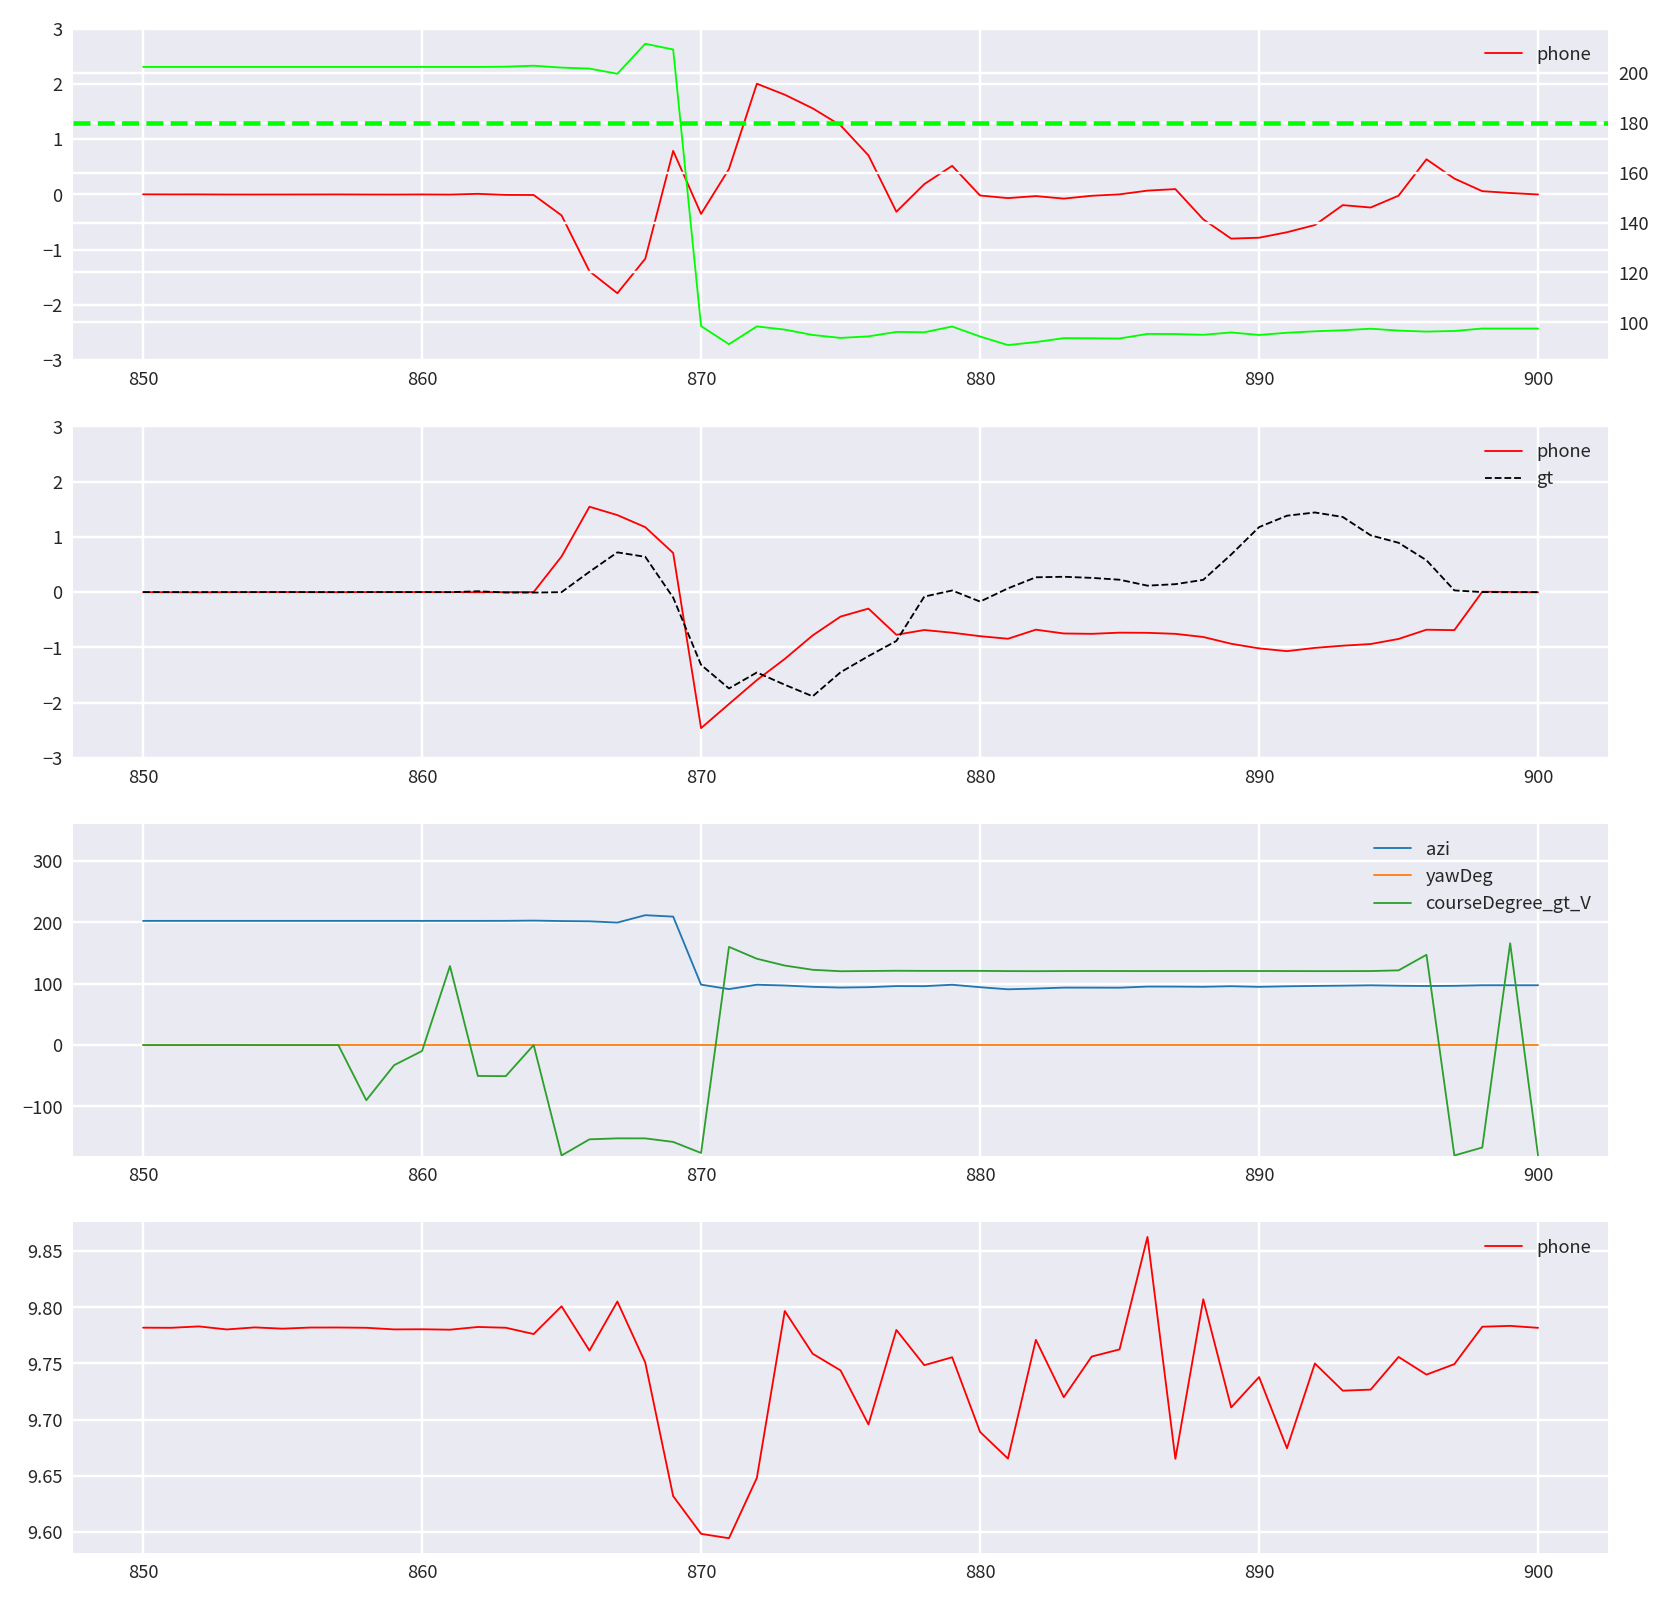

PyObject <matplotlib.legend.Legend object at 0x7faa1ee45748>

In [70]:
fig, ax = plt.subplots(4,1)
n = size(gdf,1)
s = 850
n = 900
util_fc.XY2acce(gdf, :X_gt, :Y_gt)

#ax[1].plot(s:n, gdf.Ax_calibre[s:n], label="phone", lw=0.6, color="red")
#ax[1].plot(s+1:n-2, gdf.Ax_X_gt[s+1:n-2], label="gt", lw=0.6, color="black", ls="--")
ax[1].plot(s:n, gdf.Ax_calibre[s:n] - gdf.Ax_X_gt[s:n], label="phone", lw=0.6, color="red")
ax[1].legend()
ax[1].set_ylim((-3,3))
ax2 = twinx(ax[1])
t = gdf.azi[s:n]
ax2.plot(s:n, t , label="azi", lw=0.6, color="lime")
ax2.axhline(180.0,  color="lime", ls="--")
#ax2.legend()

ax[2].plot(s:n, gdf.Ay_calibre[s:n], label="phone", lw=0.6,color="red")
ax[2].plot(s:n, gdf.Ay_Y_gt[s:n], label="gt", lw=0.6, color="black", ls="--")
ax[2].legend()
ax[2].set_ylim((-3,3))
#ax2.legend()

#ax[3].plot(s:n, gdf.pitch[s:n], label="pitch", lw=0.6)
#ax[3].plot(s:n, gdf.roll[s:n], label="roll", lw=0.6)
t = gdf.azi[s:n]
# t[t.>300] .= t[t.>300] .-360.0  #.- div.(t, 180.0) .* 180
ax[3].plot(s:n, t , label="azi", lw=0.6)
ax[3].plot(s:n, gdf.pitchDeg[s:n] , label="yawDeg", lw=0.6)
ax[3].plot(s:n, gdf.courseDegree_gt_V[s:n] .-180 , label="courseDegree_gt_V", lw=0.6)
ax[3].legend()
ax[3].set_ylim((-180,360))

ax[4].plot(s:n, gdf.Az_calibre[s:n] , label="phone", lw=0.6,color="red")
ax[4].legend()

In [56]:
x = (1:6)
x[end]

6

In [283]:
gdf

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,time_UTC,AccelXMps2_lowpass,AccelYMps2_lowpass,AccelZMps2_lowpass,GyroXRadPerSec_lowpass,GyroYRadPerSec_lowpass,GyroZRadPerSec_lowpass,MagXMicroT_lowpass,MagYMicroT_lowpass,MagZMicroT_lowpass,lngDeg_gt,latDeg_gt,heightAboveWgs84EllipsoidM_gt,timeSinceFirstFixSeconds_gt,hDop_gt,vDop_gt,speedMps_gt,courseDegree_gt,X_obs,Y_obs,lngDeg_centre,latDeg_centre,X_gt,Y_gt,Vx_X_obs,Vy_Y_obs,Ax_X_obs,Ay_Y_obs,Vx_X_obs_m1,Vy_Y_obs_m1,X_gt_m1,Y_gt_m1,Vx_gt,Vy_gt,V_obs,courseDegree_obs,courseDegree_gt_V,dist,ac,ac_m1,is_stoping,ac_lowpass,ac_lowpass_m1,pitch,roll,azi,GyroXDegPerSec_lowpass,GyroYDegPerSec_lowpass,GyroZDegPerSec_lowpass,Ax_calibre,Ay_calibre,Az_calibre,Ax_X_gt,Ay_Y_gt
,String,String,Int64,Float64,Float64,Float64,String,DateTime,Float64?,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-06-11-US-MTV-1,Pixel4,1275933942446,37.4246,-122.092,-13.2,2020-06-11-US-MTV-1_Pixel4,2020-06-11T18:05:24.446,-0.32441,9.74207,1.03334,-5.31769,4.97311,-15.4341,17.381,-37.5037,25.0195,-122.092,37.4245,33.84,59.45,1.4,0.0,0.0,202.9,5545.55,-1179.35,-122.155,37.4352,5544.75,-1180.81,1.5046,0.211873,0.0,0.0,2.72255,5.55109,5544.75,-1180.81,-5.16102e-8,7.76894e-5,1.51945,171.985,270.038,1.65932,9.80209,9.80208,1,9.80209,9.80208,263.929,178.111,73.8537,-304.681,284.938,-884.31,0.00310335,0.000493664,9.80209,8.66363e-66,1.18345e243
2,2020-06-11-US-MTV-1,Pixel4,1275933943446,37.4246,-122.092,-21.4,2020-06-11-US-MTV-1_Pixel4,2020-06-11T18:05:25.446,-0.322638,9.74211,1.03343,-5.68348,-0.260738,-13.4588,17.3049,-37.5448,24.4167,-122.092,37.4245,33.84,60.45,1.4,0.0,0.0,202.9,5547.05,-1179.13,-122.155,37.4352,5544.75,-1180.81,2.72255,5.55109,1.21795,5.33922,0.946704,0.599952,5544.75,-1180.81,-6.19086e-5,-7.77305e-5,6.18279,116.126,51.4644,2.83918,9.80208,9.80196,1,9.80208,9.80196,263.929,178.111,73.8537,-325.639,-14.9392,-771.135,0.00253341,-0.00118691,9.80208,6.18569e-5,0.00015542
3,2020-06-11-US-MTV-1,Pixel4,1275933944446,37.4246,-122.092,-26.04,2020-06-11-US-MTV-1_Pixel4,2020-06-11T18:05:26.446,-0.331668,9.74135,1.03659,-5.8075,0.18828,-13.5344,17.3309,-37.5592,24.9672,-122.092,37.4245,33.84,61.45,1.4,0.0,0.0,202.9,5549.77,-1173.58,-122.155,37.4352,5544.75,-1180.81,0.946704,0.599952,-1.77585,-4.95114,-4.64279,-6.34037,5544.75,-1180.81,6.19602e-5,4.11044e-8,1.1208,147.636,180.038,8.79393,9.80196,9.80181,1,9.80196,9.80181,263.929,178.111,73.8537,-332.745,10.7876,-775.463,0.00194845,0.00839308,9.80195,-0.000123869,-7.77716e-5
4,2020-06-11-US-MTV-1,Pixel4,1275933945446,37.4246,-122.092,-30.05,2020-06-11-US-MTV-1_Pixel4,2020-06-11T18:05:27.446,-0.31548,9.74298,1.02487,-1.67873,-39.0148,-15.8019,17.6497,-37.3017,25.3635,-122.092,37.4245,33.84,62.45,1.4,0.0,0.0,202.9,5550.72,-1172.98,-122.155,37.4352,5544.75,-1180.81,-4.64279,-6.34037,-5.58949,-6.94032,-0.963737,-1.60993,5544.75,-1180.81,-6.18938e-5,-9.99294e-5,7.85848,306.214,58.2269,9.83651,9.80181,9.80452,1,9.80181,9.80452,263.929,178.111,73.8537,-96.1844,-2235.38,-905.385,0.00880857,-0.0104501,9.8018,0.000123854,9.99705e-5
5,2020-06-11-US-MTV-1,Pixel4,1275933946446,37.4246,-122.092,-31.57,2020-06-11-US-MTV-1_Pixel4,2020-06-11T18:05:28.446,-0.327113,9.74376,1.03965,-11.5916,24.637,-9.27507,17.5525,-37.3312,24.9321,-122.092,37.4245,33.84,63.45,1.4,0.0,0.0,202.9,5546.08,-1179.32,-122.155,37.4352,5544.75,-1180.81,-0.963737,-1.60993,3.67905,4.73044,2.69067,0.245957,5544.75,-1180.81,6.18422e-5,0.000177619,1.87635,300.906,250.803,1.98531,9.80452,9.80337,1,9.80452,9.80337,263.929,178.111,73.8537,-664.148,1411.59,-531.422,-0.00202159,0.00470908,9.80452,-0.00

In [216]:
gdf[:,[:pitch, :roll, :azi, :GyroXDegPerSec_lowpass, :GyroYDegPerSec_lowpass,:GyroZDegPerSec_lowpass]]

,pitch,roll,azi,GyroXDegPerSec_lowpass,GyroYDegPerSec_lowpass,GyroZDegPerSec_lowpass
,Float64,Float64,Float64,Float64,Float64,Float64
1,83.9286,1.88879,-119.366,-304.681,284.938,-884.31
2,83.9286,1.88879,-119.366,-325.639,-14.9392,-771.135
3,83.9286,1.88879,-119.366,-332.745,10.7876,-775.463
4,83.9286,1.88879,-119.366,-96.1844,-2235.38,-905.385
5,83.9286,1.88879,-119.366,-664.148,1411.59,-531.422
6,83.9286,1.88879,-119.366,-336.735,-108.113,-722.741
7,83.9286,1.88879,-118.743,-345.863,-26.9698,-774.028
8,83.9147,1.882,-118.771,-361.47,-107.218,-715.201
9,83.9147,1.882,-118.771,-386.771,-108.031,-760.802


In [ ]:
function rot_x(data::Array{Float64,2}, θ::Float64)::Array{Float64,2}
    R = [1.     0.      0.;
         0. cos(θ) -sin(θ);
         0. sin(θ)  cos(θ)]
    return R*data
end

function rot_y(data::Array{Float64,2}, θ::Float64)::Array{Float64,2}
    R = [ cos(θ) 0. sin(θ);
              0. 1.     0;
         -sin(θ) 0. cos(θ)]
    return R*data
end

function rot_z(data::Array{Float64,2}, θ_arr::Vector{F})::Array{Float64,2}
    res = similar(data, F)
    for i in 1:size(data, 1)
        θ = θ_arr[i]
        R = [cos(θ) -sin(θ) 0.;
             sin(θ)  cos(θ) 0.;
             0.      0. 1.]
        res[i ,: ] = R*data[i,:]
    end
    return res
end
function rot_azi(data::Array{Float64,2}, θ_arr::Vector{F})::Array{Float64,2}
    res = similar(data, F)
    for i in 1:size(data,1)
        θ = θ_arr[i]
        R = [cos(θ) -sin(θ);
             sin(θ)  cos(θ)
            ]
        res[i ,: ] = R*data[i,:]
    end
    return res
end

function rot(data::Array{Float64,2}, roll::Array{Float64,1})::Array{Float64,2}
    x = rot_x(Array(data'), roll[1])
    y = rot_y(x,  roll[2])
    z = rot_z(y,  roll[3])
    return Array(z')
end

function rot2(data::Array{Float64,2}, roll::Array{Float64,1})::Array{Float64,2}
    R1 = [1.     0.      0.;
         0. cos(roll[1]) -sin(roll[1]);
         0. sin(roll[1])  cos(roll[1])]
    
    R2 = [cos(roll[2]) 0. sin(roll[2]);
          0.     1.     0;
         -sin(roll[2]) 0. cos(roll[2])]
    
    R3 = [cos(roll[3]) -sin(roll[3]) 0.;
         sin(roll[3])  cos(roll[3]) 0.;
             0.      0. 1.]
    R = R3 * R2 * R1
    
    return Array((R * Array(data'))')
end


In [ ]:
util_fc.XY2Vel(train_df_concat, :X_obs, :Y_obs, :Vx_obs, :Vy_obs)
# train_df_concat[:, :car_azi] = atan.(train_df_concat.Vy_obs, train_df_concat.Vx_obs) .|> rad2deg;
@transform!(train_df_concat, car_azi = atan.(:Vy_obs, :Vx_obs) .|> rad2deg)
train_df_concat

In [ ]:
gd1 = groupby(train_df_concat, :collectionName)
s = length(gd1)
fig, ax = plt.subplots(s, 1, figsize=(8,3*s))
for (i, gdf1) in enumerate(gd1)
    gd2 = groupby(gdf1, :phone)
    for gdf2 in gd2
        y = gdf2.AccelXMps2_lowpass # |> skipmissing |> collect
        x = gdf2.time_UTC
        mask = .~(ismissing.(gdf2.AccelXMps2_lowpass))
        y = y[mask]
        x = x[mask]
        n = length(y)
        ax[i].plot(x, y, label=gdf2.phone[1])
        ax[i].set_title(gdf1.collectionName[1])
        ax[i].legend()
    end
end

In [ ]:
@by(train_df_concat, :phone, tmax = maximum(:time_UTC),tmin = minimum(:time_UTC), t = 1/ 1000/60 .* Dates.value.(maximum(:time_UTC) - minimum(:time_UTC)))

In [ ]:
function norm2(A::Array{F,2}; dims::Int)::F
    B = sum(x -> x^2, A; dims=dims)
    # B .= sqrt.(B)
    return sqrt(sum(B))
end

function fixd_angle(df::DataFrame)
    df[!, :fixed_angle_x] = similar(df[!, :X_obs], F)
    df[!, :fixed_angle_y] = similar(df[!, :X_obs], F)
    df[!, :fixed_angle_z] = similar(df[!, :X_obs], F)
    df[!, :fixed_angle_x] = similar(df[!, :X_obs], F)
    df[!, :fixed_angle_y] = similar(df[!, :X_obs], F)
    gd = groupby(df, :phone)
    @showprogress 1 for gdf in gd
        d = @select(gdf, :time_UTC, :acce1_fm_obs_x, :acce1_fm_obs_y, :AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass, :car_azi)
        mask = .~(ismissing.(d.AccelXMps2_lowpass))
        d = d[mask, :]
        phone_acc = @select(d, :AccelXMps2_lowpass, :AccelYMps2_lowpass, :AccelZMps2_lowpass) |> Array{F}
        gps_acc = @select(d, :acce1_fm_obs_x, :acce1_fm_obs_y, acce1_fm_obs_z=:acce1_fm_obs_y) |> Array{F}
        car_azi =  @select(d, :car_azi) |> Array{F} |> vec
        gps_acc[:, 3] .= 9.81
         θ_ = [0.1, 0.1, 0.5pi, 9.81]
        #θ_  = deg2rad.([80.97270603943826 ,1.4599843179897447, 282.8033561784252])
        lower = [0.0, 0.0, 0.0, 9.7]
        upper = [2pi, 2pi, 2pi, 10.0]
    
        function f(θ::Array{F,1})::F
            gps_acc[:, 3] .= θ[4]
            res = gps_acc - rot_z(rot2(phone_acc, θ), car_azi)
            res_norm = norm2(res, dims=2)
            return res_norm
        end
        # @time ff(θ_)
        res = optimize(f, lower, upper, θ_) |> Optim.minimizer
        @show(res)
        gdf[:, :fixed_angle_x] .= rad2deg(res[1])
        gdf[:, :fixed_angle_y] .= rad2deg(res[2])
        gdf[:, :fixed_angle_z] .= rad2deg(res[3])
        return 
    end
    # return res
end
fixd_angle(train_df_concat)

In [ ]:
azi = train_df_concat.car_azi .|> deg2rad
fixed_angle = deg2rad.([first(train_df_concat.fixed_angle_x), first(train_df_concat.fixed_angle_y), first(train_df_concat.fixed_angle_z)])

In [ ]:
div(length(arr), 3)

In [ ]:
azi

In [ ]:
gdf = groupby(train_df_concat, :phone)[1]
arr = @select(gdf, :AccelXMps2_lowpass, :AccelYMps2_lowpass,:AccelZMps2_lowpass) |> Array
arr = skipmissing(arr) |> collect
arr = reshape(arr, (div(length(arr), 3), 3))
a = rot2(arr, fixed_angle)[:, 1:3]
# acce = rot_azi(a, azi)
fig, ax = plt.subplots(7,1, figsize=(12,8))
    ax[1].plot(1:size(a,1), a[:,1])
    ax[2].plot(1:size(a,1), a[:,2])
    ax[3].plot(1:size(a,1), a[:,3])
    ax[4].plot(1:size(a,1), gdf.X_gt[1:size(a,1)])
    ax[5].plot(1:250, a[1:250,1])
    ax[6].plot(1:250, a[1:250,2])
    ax[7].plot(1:250, a[1:250,3])

In [ ]:
@by(train_df_concat, :phone, x=first(:fixed_angle_x), y=first(:fixed_angle_y), z=first(:fixed_angle_z))
@select(train_df_concat[1:1000, :], x=first(:), y=first(:fixed_angle_y), z=first(:fixed_angle_z)) |> Array

In [ ]:
train_df_concat